In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import FileLink, FileLinks
from sklearn.metrics import mean_squared_error

In [2]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

## FluView Forecasting: Introduction

Earlier this year, preliminary time series modeling was conducted on FluView data. The purpose of this analysis was to develop a baseline model for forecasting cases of all types of flu for North America. We used about 5 years worth of data obtained from the CDC to develop this model. We found the data had seasonal components and was nonstationary, and our recommended model is a "nonstationary ensemble" composed of an ARUMA model (specifically ARUMA(5,0,2), s = 52) and multivariate neural network. In-depth EDA and model testing can be found at the link below:

In [3]:
FileLink('Time_Series_Flu_Data_Forecasting.html')

C:\Users\micha\QTW-CaseStudy4\Time_Series_Flu_Data_Forecasting.html

We will continue this analysis with more depth and breadth. Specifically, we will introduce more data into the analysis, going back to the 2010 flu season. This is a critical time period for 2 reasons: this was data gathered prior to the FluView weekly report which began in 2015 (and thus has combined clinical and public health data, whereas FluView only contains public health). We would like to determine if the methods of gathering these data confound our already-established model. Additionally, the H1N1 swine flu epidemic ended around the beginning of 2010, and we are interested in seeing the effects this has had on tracing the flu from then until now.

Since we will also be conducting analysis on the different sub-types of flu, we will not introduce our neural network component into this analysis; instead, we will focus on our ARUMA model.

## Load and Examine the Data

In [4]:
flu2015 = pd.read_csv('Data/WHO_NREVSS_Public_Health_Labs.csv', sep=',', header=0, skiprows=1)
flu2015

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,A (2009 H1N1),A (H3),A (Subtyping not Performed),B,BVic,BYam,H3N2v
0,National,X,2015,40,1139,4,65,2,10,0,1,0
1,National,X,2015,41,1152,5,41,2,7,3,0,0
2,National,X,2015,42,1198,10,50,1,8,3,2,0
3,National,X,2015,43,1244,9,31,4,9,1,4,0
4,National,X,2015,44,1465,4,23,4,9,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
241,National,X,2020,21,536,0,0,1,0,0,0,0
242,National,X,2020,22,515,2,0,1,1,0,0,0
243,National,X,2020,23,322,0,0,0,1,0,0,0
244,National,X,2020,24,305,0,0,0,1,0,0,0


In [5]:
flu2010 = pd.read_csv('Data/WHO_NREVSS_Combined_prior_to_2015_16.csv', sep=',', header=0, skiprows=1)
flu2010

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,PERCENT POSITIVE,A (2009 H1N1),A (H1),A (H3),A (Subtyping not Performed),A (Unable to Subtype),B,H3N2v
0,National,X,2010,40,3600,2.13889,7,0,18,29,0,23,0
1,National,X,2010,41,4006,3.19521,13,0,36,43,0,36,0
2,National,X,2010,42,4112,3.38035,8,0,35,51,0,45,0
3,National,X,2010,43,4240,3.91509,13,0,56,45,0,52,0
4,National,X,2010,44,4608,5.36024,12,0,61,68,0,106,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,National,X,2015,35,6115,2.27310,3,0,64,43,0,29,0
257,National,X,2015,36,6786,2.18096,1,0,74,35,0,38,0
258,National,X,2015,37,7694,2.57343,4,0,91,56,0,47,0
259,National,X,2015,38,8855,1.88594,1,0,58,62,0,46,0


In [6]:
date_index = pd.date_range(start="2010-10-3", end="2020-6-14", freq='W-SUN')
TS = pd.DataFrame(pd.concat([flu2010['TOTAL SPECIMENS'],flu2015['TOTAL SPECIMENS']]))
FluCases = TS.set_index(date_index)

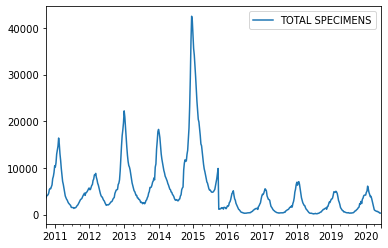

In [7]:
FluCases.plot()
plt.show()

The realization of the Flu Time Series Data show clear peaks repeating around every 50 weeks with the most pronounced peak around week 125. This suggests an annaul trend in the data and is consistent with the fact that influenza viruses typically circulate every year. We suspect the seasonal trend in the data with will be a factor of s = 52 weeks (~1 year). The peaks repeating every year indicate that the mean depends on time and is not constant throughout the time series. Due to this violation, we suspect that time series is a **non-stationary process**.

Assessing the constant variance assumption over time, the peaks all appear to be approximately the same size despite Week 125 being more pronounced. There is some evidence to suggest that the variances do not depend on time, but this is a questional assumption because we can not assume that the mean is constant throughout the time series.

In [8]:
date_index = pd.date_range(start="2015-10-4", end="2020-6-14", freq='W-SUN')
TS = pd.DataFrame(flu2015['TOTAL SPECIMENS'])
FluCases2015 = TS.set_index(date_index)

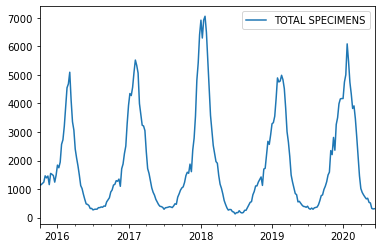

In [9]:
FluCases2015.plot()
plt.show()

Aggregating the data by weeks, we can see that flu activity begins to increase towards the end of the year and peak around the middle of February, (6th week of the year). Activity begins to fall off again around the end of March (roughly the 12th week). This suggests that these trends in flu activity over the past 5 years follow a periodic behavior that cycles annually.

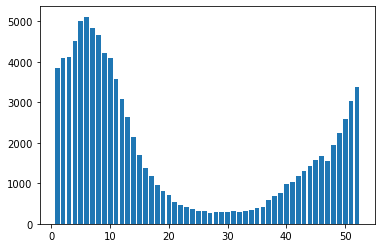

In [10]:
WeekAggregate2015 = flu2015.groupby("WEEK").mean()["TOTAL SPECIMENS"]
plt.bar(WeekAggregate2015.index,WeekAggregate2015)
plt.show()

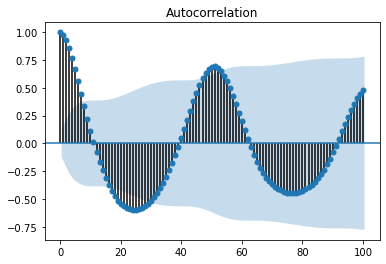

In [11]:
plot_acf(FluCases2015, lags=100)
plt.show()

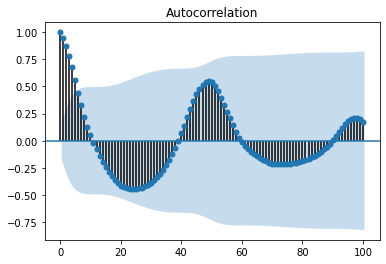

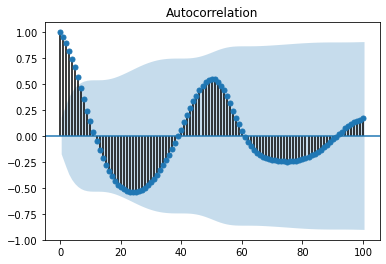

In [12]:
plot_acf(FluCases2015[0:123], lags=100)
plot_acf(FluCases2015[123:246], lags=100)
plt.show()

Based on these analyses, we know the data is likely nonstationary. We will confirm with rolling means plots and the Dickey-Fuller test.

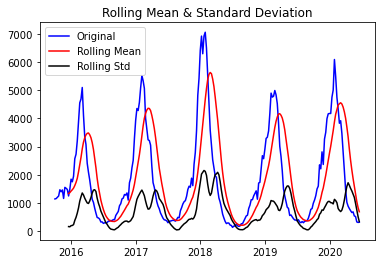

Results of Dickey-Fuller Test:
Test Statistic                  -1.573505
p-value                          0.496887
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


C:\Users\micha\Anaconda3\envs\qtw\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


In [13]:
test_stationarity(FluCases2015)

With a p-value of 0.49, we fail to reject the null hypothesis, therefore confirming the data is non-stationary. We established in our prior analysis that we could break down yearly trends at a weekly rate. Let's confirm that with a decomposition:

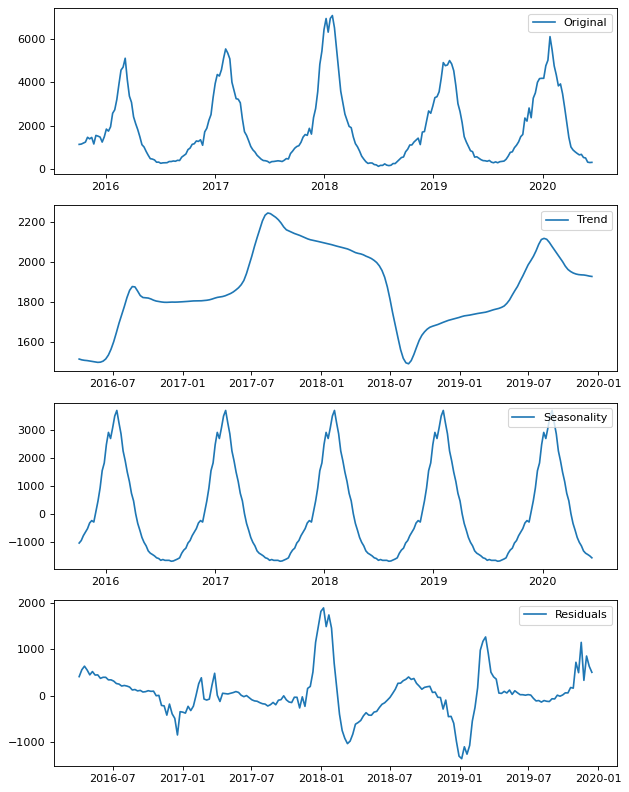

In [14]:
decomposition = seasonal_decompose(FluCases2015)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(num=None, figsize=(8, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(411)
plt.plot(FluCases2015, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

The yearly decomposition demonstrates very clear annual cyclic behavior. The monthly breakdown is less clear, as there are some trends...January seems to demonstrate peaks year over year, but it is not consistent. In 2019 there was a significant drop in the residuals for this month, and in the trend line July is very inconsistent. Since we established that a frequency of 52 works best, and this is confirmed with the above plots, we will use this information in model building.

## Model Building

We know from our previous model-building that the optimal seasonal decomposition is s=52. Given that we are trying to build a simple ARIMA model without seasonal components, we will "stationarize" the data by removing the seasonal component.

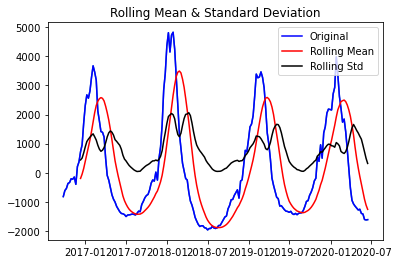

Results of Dickey-Fuller Test:
Test Statistic                  -4.250807
p-value                          0.000540
#Lags Used                      12.000000
Number of Observations Used    182.000000
Critical Value (1%)             -3.466800
Critical Value (5%)             -2.877555
Critical Value (10%)            -2.575308
dtype: float64


In [15]:
moving_avg = FluCases2015.rolling(52).mean()
FluCases2015Stat = FluCases2015 - moving_avg
plt.plot(FluCases2015Stat)
plt.title("Flu Data with Rolling Mean Removed")
test_stationarity(FluCases2015Stat.dropna())

We also took a second order difference of d=1 in our original analysis. We will replicate that here:

In [16]:
FluCases2015Diff = FluCases2015Stat-FluCases2015Stat.shift(1)

With the seasonal component removed, the data is much more stationary. We will proceed with the ARIMA model with these data. Since we established that the best order for ARUMA with s=52 is 5,0,2, we will try this order in our initial model.

                              ARMA Model Results                              
Dep. Variable:        TOTAL SPECIMENS   No. Observations:                  194
Model:                     ARMA(5, 2)   Log Likelihood               -1377.242
Method:                       css-mle   S.D. of innovations            292.290
Date:                Mon, 29 Jun 2020   AIC                           2772.484
Time:                        22:54:46   BIC                           2801.894
Sample:                    10-02-2016   HQIC                          2784.393
                         - 06-14-2020                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -2.1031     65.537     -0.032      0.974    -130.553     126.346
ar.L1.TOTAL SPECIMENS    -0.0523      0.123     -0.427      0.669      -0.292       0.188
ar.L2.TO

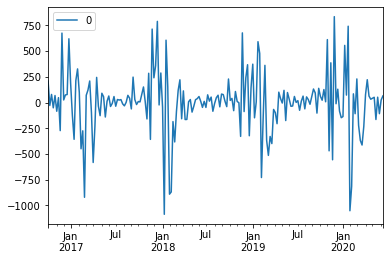

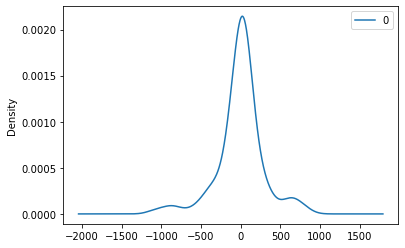

                 0
count   194.000000
mean     -0.869190
std     293.382911
min   -1085.984035
25%     -87.830016
50%      19.436335
75%      88.794428
max     834.305198


In [20]:
model = ARIMA(FluCases2015Diff.dropna(), order=(5,0,2), freq='W')
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

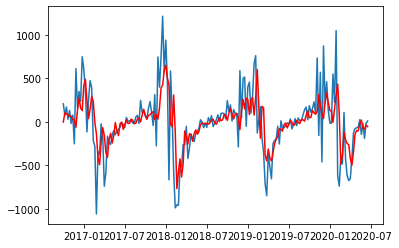

In [21]:
plt.plot(FluCases2015Diff)
plt.plot(model_fit.fittedvalues, color='red')

This looks reasonable. The frequency plot appears to be relatively evenly distributed - we are not seeing the out of season differences we saw in the raw data. The density is a Gaussian distribution without being overfit - this also bears out when overlaying the fitted values. We will next try in- and out-of-sample forecasts to test this model.

## Forecasting

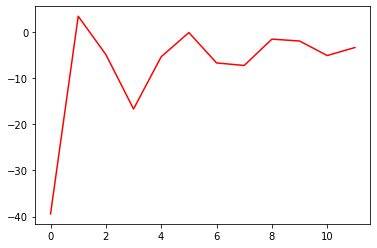

In [24]:
##Out Of Sample
fore = model_fit.forecast(steps=12, alpha=.1)[0]
plt.plot(fore, color='red')

In [26]:
X = FluCases2015Diff.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
error = mean_squared_error(test, predictions)
print(error)

134373.84909426485


The forecast of this model has an out of sample MSE of 134,373.849.